<a href="https://colab.research.google.com/github/ktsim01/FIFA-World-Cup-2022-Prediction/blob/main/World_Cup_2022_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
results = pd.read_csv('results.csv')

In [3]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Create new columns showing who won and the goal differences

In [4]:
winner = []
for i in range (len(results['home_team'])):
    if results ['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results ['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Draw')
results['winning_team'] = winner

#adding goal difference column
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Scotland,3


Checking what the data looks like with a box plot.

([<matplotlib.axis.XTick at 0x7f3949111a90>,
 [Text(0, 0, 'Home Score'), Text(0, 0, 'Away Score')])

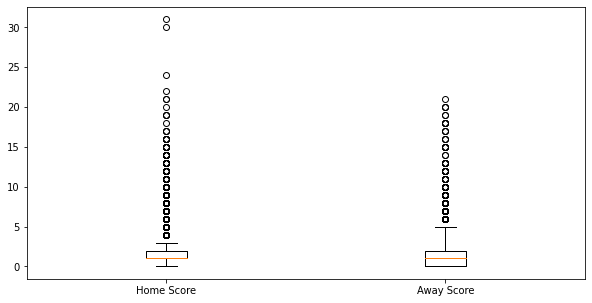

In [5]:
fig = plt.figure(figsize =(10, 5))
plt.boxplot([results["home_score"],results["away_score"]])
plt.xticks([1,2], ["Home Score", "Away Score"])

Let's remove all the outliers so as to make the model more accurate

In [6]:
goal_max=15 #Maximum goals one team can score is limited to 15
results=results[(results["home_score"]<goal_max) & (results["away_score"]<goal_max)]
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Scotland,3


Group Stage for the Qatar World Cup 2022:

**Group A**: Qatar, Ecuador, Senegal, Netherlands 

**Group B**: England, Iran, USA, Wales 

**Group C**: Argentina, Saudi Arabia, Mexico, Poland 

**Group D**: France, Denmark, Tunisia, Australia 

**Group E**: Spain, Germany, Japan , Costa Rica

**Group F**: Belgium, Canada, Morocco, Croatia 

**Group G**: Brazil, Serbia, Switzerland, Cameroon 

**Group H**: Portugal, Ghana, Uruguay, South Korea

From here, we will filter the data to the selected teams and only use data after 1930. In addition, irrelevant data will be dropped

In [8]:
worldcup_teams = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'
                  'England', 'Iran', 'USA', 'Wales',
                  'Argentina', 'Saudia Arabia', 'Mexico', 'Poland'
                  'France', 'Denmark', 'Tunisia', 'Australia'
                  'Spain', 'Germany', 'Japan', 'Costa Rica'
                  'Belgium', 'Canada', 'Morocco', 'Croatia'
                  'Brazil', 'Serbia', 'Switzerland', 'Cameroon',
                  'Portugal', 'Ghana', 'Urugay', 'South Korea']

df_teams_home = results[results['home_team'].isin(worldcup_teams)]
df_teams_away = results[results['away_team'].isin(worldcup_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates()
df_teams.count()

year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year
df_teams_1930 = df_teams[df_teams.match_year >= 1930]
df_teams_1930.head()

df_teams_1930 = df_teams.drop(['date', 'home_score', 'away_score', 'tournament', 'city', 'country',
                               'goal_difference', 'match_year', 'neutral'], axis = 1)

df_teams_1930.head()

,home_team,away_team,winning_team
7,Wales,Scotland,Scotland
12,Wales,Scotland,Scotland
14,Wales,England,England
18,Wales,Scotland,Scotland
20,Wales,Northern Ireland,Wales


Establishing prediction label to build our model

In [28]:
df_teams_1930 = df_teams_1930.reset_index(drop=True)
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.home_team,'winning_team']=2
df_teams_1930.loc[df_teams_1930.winning_team == 'Draw', 'winning_team']=1
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.away_team, 'winning_team']=0

df_teams_1930.head()

,home_team,away_team,winning_team
0,Wales,Scotland,-1
1,Wales,Scotland,-1
2,Wales,England,-1
3,Wales,Scotland,-1
4,Wales,Northern Ireland,1


Now, we will convert the categorical variables into continuous variables.

In [10]:
final = pd.get_dummies(df_teams_1930, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
final.head()

,winning_team,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andalusia,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will use Logistic Regression to create our machine learning model as it is fit for situations like this where we are trying to predict a binary outcome: win or loss.

In [12]:
final.head()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print('Training set accuracy ', '%.3f'%(score))
print('Test set accuracy ', '%.3f'%(score2))

Training set accuracy  0.579
Test set accuracy  0.553


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Incoporating the FIFA ranking as of June 2022 and the fixtures for the group stage, we will now deploy the machine learning model.

In [20]:
# Loading new datasets
fixtures = pd.read_csv('fixtures.csv')
ranking = pd.read_csv('fifa_rankings.csv', encoding = 'latin-1')

# List for storing the group stage games
pred_set = []

# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

,Match Number,first_position,second_position,Round Number,Date,Location,Home Team,Away Team,Group,Result
43,44,31.0,12.0,3,01/12/2022 19:00,Al Bayt Stadium,Costa Rica,Germany,Group E,NaN
44,45,60.0,13.0,3,02/12/2022 15:00,Al Janoub Stadium,Ghana,Uruguay,Group H,NaN
45,46,29.0,8.0,3,02/12/2022 15:00,Education City Stadium,South Korea,Portugal,Group H,NaN
46,47,25.0,14.0,3,02/12/2022 19:00,Stadium 974,Serbia,Switzerland,Group G,NaN
47,48,37.0,1.0,3,02/12/2022 19:00,Lusail Stadium,Cameroon,Brazil,Group G,NaN


In [21]:
# Loop to add teams to new prediction dataset based on the ranking position of each team
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

,home_team,away_team,winning_team
0,Netherlands,Senegal,None
1,England,Iran,None
2,Ecuador,Qatar,None
3,USA,Wales,None
4,Argentina,Saudi Arabia,None


In [22]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andalusia,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here are the predictions

In [25]:
predictions = logreg.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + ' and ' + backup_pred_set.iloc[i, 0])
    if predictions[i] == -1:
        print('Winner: ' + backup_pred_set.iloc[i, 1])
    elif predictions[i] == 0:
        print('Draw')
    elif predictions[i] == 1:
        print('Winner: ' + backup_pred_set.iloc[i, 0])
    print('Probability of Draw: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i,0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print('')

Senegal and Netherlands
Winner: Netherlands
Probability of Draw:  0.277
Probability of Netherlands winning:  0.113

Iran and England
Winner: England
Probability of Draw:  0.315
Probability of England winning:  0.120

Qatar and Ecuador
Winner: Ecuador
Probability of Draw:  0.237
Probability of Ecuador winning:  0.175

Wales and USA
Winner: Wales
Probability of Draw:  0.192
Probability of USA winning:  0.454

Saudi Arabia and Argentina
Winner: Argentina
Probability of Draw:  0.210
Probability of Argentina winning:  0.047

Tunisia and Denmark
Winner: Denmark
Probability of Draw:  0.269
Probability of Denmark winning:  0.126

Poland and Mexico
Winner: Mexico
Probability of Draw:  0.204
Probability of Mexico winning:  0.378

Australia and France
Winner: France
Probability of Draw:  0.358
Probability of France winning:  0.078

Morocco and Croatia
Winner: Croatia
Probability of Draw:  0.317
Probability of Croatia winning:  0.210

Japan and Germany
Winner: Germany
Probability of Draw:  0.148
P